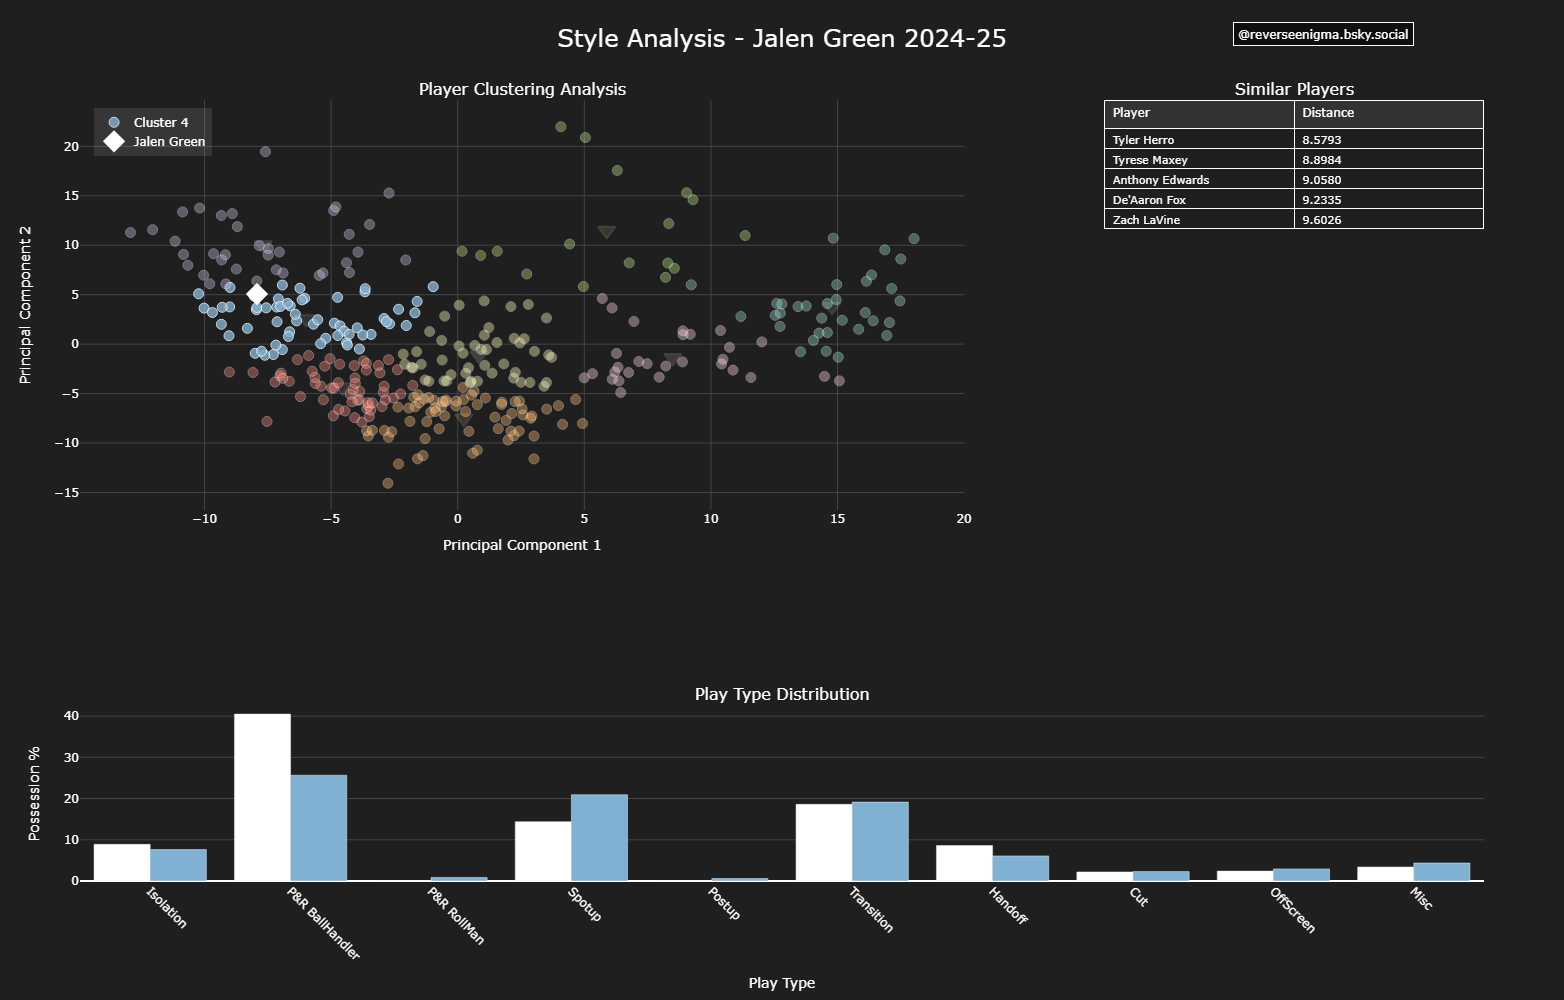

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def create_player_visualization(selected_player_id, season, n_neighbors=5):
    year=int(season.split('-')[0])+1
    season_df = pd.read_csv(f'nba_analysis_{year}.csv')
    
    # Filter for selected player by ID
    player_data = season_df[season_df['PLAYER_ID'] == selected_player_id].iloc[0]
    selected_player = player_data['PLAYER_NAME']  # Get player name for display
    player_cluster = player_data['Cluster']
    

    
    # Calculate similar players
    pca_cols = [col for col in season_df.columns if col.startswith('PCA_')]
    X = season_df[pca_cols].values
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
    distances, indices = nbrs.kneighbors(player_data[pca_cols].values.reshape(1, -1))
    similar_players = season_df.iloc[indices[0][1:]]['PLAYER_NAME'].tolist()

    player_color='#ffffff'
    
    # Define cluster colors using Set3 palette
    cluster_colors = {
        cluster: px.colors.qualitative.Set3[cluster % len(px.colors.qualitative.Set3)]
        for cluster in season_df['Cluster'].unique()
    }
    
    # Create subplot layout
    fig = make_subplots(
        rows=2, cols=2,
        column_widths=[0.7, 0.3],
        row_heights=[0.7, 0.3],
        specs=[
            [{"type": "scatter"}, {"type": "table"}],
            [{"type": "bar", "colspan": 2}, None]
        ],
        subplot_titles=(
            'Player Clustering Analysis',
            'Similar Players',
            'Play Type Distribution'
        )
    )
    
    # Add cluster centroids with matching colors
    cluster_centroids = season_df.groupby('Cluster')[['PCA_1', 'PCA_2']].mean()
    for cluster in cluster_centroids.index:
        fig.add_trace(
            go.Scatter(
                x=[cluster_centroids.loc[cluster, 'PCA_1']],
                y=[cluster_centroids.loc[cluster, 'PCA_2']],
                mode='markers',
                marker=dict(
                    symbol='triangle-down',
                    opacity=.15,
                    size=15,
                    color=cluster_colors[cluster],
                    line=dict(width=2, color='#FFFFFF')
                ),
                name=f'Cluster {cluster} Center',
                hovertext=f'Cluster {cluster} Center',
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Add all players (colored by cluster)
    for cluster in season_df['Cluster'].unique():
        cluster_data = season_df[season_df['Cluster'] == cluster]
        default_opacity=.4
        opacity = np.where(cluster == player_cluster, 0.8, default_opacity)
        show_legend = False if opacity == default_opacity else True
        
        fig.add_trace(
            go.Scatter(
                x=cluster_data['PCA_1'],
                y=cluster_data['PCA_2'],
                mode='markers',
                marker=dict(
                    size=10,
                    opacity=opacity,
                    color=cluster_colors[cluster],
                    line=dict(width=1, color='#FFFFFF')
                ),
                text=cluster_data['PLAYER_NAME'],
                showlegend=show_legend,
                name=f'Cluster {cluster}',
                hovertemplate='<b>%{text}</b><br>PCA_1: %{x:.2f}<br>PCA_2: %{y:.2f}<br><extra></extra>'
            ),
            row=1, col=1
        )
    
    # Highlight selected player
    fig.add_trace(
        go.Scatter(
            x=[player_data['PCA_1']],
            y=[player_data['PCA_2']],
            mode='markers+text',
            marker=dict(
                size=15,
                color=player_color,
                symbol='diamond',
                line=dict(width=2, color='#FFFFFF')
            ),
            #text=[selected_player],
            #textposition='top center',
            #textfont=dict(color='white'),
            name=selected_player,
            hovertemplate='<b>%{text}</b><br>PCA_1: %{x:.2f}<br>PCA_2: %{y:.2f}<br><extra></extra>',
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Similar players table
    # Assuming you've already saved the similar players data to a CSV file
    similar_players_df = pd.read_csv(f'{year}_similar_players.csv')
    
    # Find the row for the specific player
    player_similar_players = similar_players_df[similar_players_df['PLAYER_NAME'] == selected_player]
    
    # Extract similar player names and their corresponding distances
    similar_players = [
        player_similar_players['SIMILAR_1_NAME'].values[0],
        player_similar_players['SIMILAR_2_NAME'].values[0],
        player_similar_players['SIMILAR_3_NAME'].values[0],
        player_similar_players['SIMILAR_4_NAME'].values[0],
        player_similar_players['SIMILAR_5_NAME'].values[0]
    ]

    similar_ids = [
        player_similar_players['SIMILAR_1_ID'].values[0],
        player_similar_players['SIMILAR_2_ID'].values[0],
        player_similar_players['SIMILAR_3_ID'].values[0],
        player_similar_players['SIMILAR_4_ID'].values[0],
        player_similar_players['SIMILAR_5_ID'].values[0]
    ]
    
    similar_distances = [
        float(player_similar_players['SIMILAR_1_DISTANCE'].values[0]),
        float(player_similar_players['SIMILAR_2_DISTANCE'].values[0]),
        float(player_similar_players['SIMILAR_3_DISTANCE'].values[0]),
        float(player_similar_players['SIMILAR_4_DISTANCE'].values[0]),
        float(player_similar_players['SIMILAR_5_DISTANCE'].values[0])
    ]
    
    # Create a DataFrame with players and their distances
    similar_players_data = pd.DataFrame({
         'PLAYER_ID': similar_ids,
        'Distance': similar_distances
    })
    similar_players_data.dropna(subset='PLAYER_ID',inplace=True)
    # Merge with season data to get full player information

    similar_players_data = similar_players_data.merge(season_df, on='PLAYER_ID', how='left')

    
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Player', 'Distance'],
                font=dict(size=12, color='white'),
                fill_color='#333333',
                align='left'
            ),
            cells=dict(
                values=[
                    similar_players_data['PLAYER_NAME'],
                    similar_players_data['Distance'].apply(lambda x: f'{x:.4f}')
                ],
                font=dict(size=11, color='white'),
                fill_color='#1f1f1f',
                align='left'
            )
        ),
        row=1, col=2
    )

    


    
    # Play type distribution comparison
    playtype_cols = [col for col in season_df.columns if col.endswith('_POSS_PCT')]
    for col in playtype_cols:
        season_df[col]*=100
        player_data[col]*=100
    cluster_avg = season_df[season_df['Cluster'] == player_cluster][playtype_cols].mean()
    
    # Add player distribution bar with legend group
    fig.add_trace(
        go.Bar(
            name=selected_player,
            x=[col.replace('_POSS_PCT', '').replace('PR', 'P&R ') for col in playtype_cols],
            y=player_data[playtype_cols],
            marker_color=player_color,
            offsetgroup=0,
            legendgroup='playtype',
            showlegend=False,
            legendgrouptitle_text="Play Type Frequency vs Similar Players"
        ),
        row=2, col=1
    )
    
    # Add cluster average bar with matching color and legend group
    fig.add_trace(
        go.Bar(
            name=f'Cluster {player_cluster} Average',
            x=[col.replace('_POSS_PCT', '').replace('PR', 'P&R ') for col in playtype_cols],
            y=cluster_avg,
            marker_color=cluster_colors[player_cluster],
            offsetgroup=1,
            legendgroup='playtype',
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Update layout for dark theme
    fig.update_layout(
        height=1000,
        width=1200,
        paper_bgcolor='#1f1f1f',
        plot_bgcolor='#1f1f1f',
        showlegend=True,
        title=dict(
            text=f'Style Analysis - {selected_player} {season}',
            x=0.5,
            y=0.97,
            font=dict(color='white', size=24)
        ),
        # Split legends for different parts of the visualization
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.1)',
            font=dict(color='white'),
            tracegroupgap=30
        ),
        barmode='group'
    )
    
    # Update axes styling
    fig.update_xaxes(
        title_text="Principal Component 1",
        row=1, col=1,
        gridcolor='#444444',
        showgrid=True,
        zeroline=False,
        color='white'
    )
    fig.update_yaxes(
        title_text="Principal Component 2",
        row=1, col=1,
        gridcolor='#444444',
        showgrid=True,
        zeroline=False,
        color='white'
    )
    fig.update_xaxes(
        title_text="Play Type",
        row=2, col=1,
        color='white',
        tickangle=45
    )
    fig.update_yaxes(
        title_text="Possession %",
        row=2, col=1,
        color='white',
        gridcolor='#444444'
    )
    
    # Update subplot titles
    fig.update_annotations(font_color='white')
    
    # Add buttons for different visualization modes
    button_layer_1_height = 1.2
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                x=0.7,
                y=button_layer_1_height,
                showactive=True,
                font=dict(color='white'),
                bgcolor='#333333',
                bordercolor='#666666'
            )
        ]
    )
    fig.update_annotations(font_color='white')
    
    # Add annotation with BlueSky handle
    fig.add_annotation(
        text="@reverseenigma.bsky.social",
        xref="paper",
        yref="paper",
        x=0.95,
        y=1.1,
        showarrow=False,
        font=dict(size=12, color="white"),
        bgcolor="rgba(0, 0, 0, 0.5)",
        bordercolor="white",
        borderwidth=1,
        borderpad=4
    )
    
    return fig


player='1630224'
season='2024-25'
fig = create_player_visualization(int(player), season)

fig.show()